# 1. Introduction
In hope of ending the global COVID-19 pandemic, multiple vaccines have been rapidly developed around the world. However, vaccine hesitancy due to safety concerns is hindering its usage. Phase II and III clinical trials showed promising results regarding both efficacy and adverse effects, also in people with underlying medical conditions [Choi, 2021]. 

In this project, the effect of two different COVID-19 vaccines, namely Pfizer-BioNTech and Oxford/AstraZeneca, on people in the UK with different underlying diseases will be evaluated, aiming to shed more light on their safety. For this, the community-based UK Biobank cohort will be applied to extract the first doses of the COVID-19 vaccinations, underlying medical conditions and adverse events categorised according to the ICD-10, as well as deaths.

Specifically, the analysis will be split uf in two sections:
* Effect of the first COVID-19 vaccination dose on adverse events.
* Effect of the first COVID-19 vaccination dose on mortality.

Both sections start more generally with the full study population, are then reduced to only people with underlying medical conditions and finally, to specific  ICD-10 categories of underlying diseases. 

# 2. Methods

## Import packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from IPython.core.display import SVG
import random
random.seed(13)

#### Import data

In [2]:
# need to import this file in slightly different way because of different delimiters
clinical = pd.read_csv('data/covid19_clinical_sample.txt',sep='\t|,', engine = 'python')

In [3]:
GPic10 = pd.read_csv('data/GP_ic10_lookup.csv') 

In [4]:
mortality = pd.read_csv('data/patients_data_death_sample.csv')

In [5]:
mortality_coding = pd.read_csv('data/patients_data_death_decoding.csv')

#### Have a look at the data

In [ ]:
clinical.head()
# GP dataset from patients in the database
# each line corresponds to one incident with a date (event_dt), including vaccinations
# eid: patient number 
# value: measured value of a test or something similar

In [ ]:
GPic10.head()
#translates CTV3 codes (read_code) to ICD10 (icd10_code)

In [ ]:
mortality.head()
# contains death dates and other info such as age and cause of death

In [ ]:
mortality_coding
# coding of column names

## Preparing data

### Data Cleaning

In [ ]:
# drop unnecessary columns
clinical.drop(columns = ['code_type', 'value'], inplace = True)

In [ ]:
pd.isnull(clinical).sum()
# no NaN

In [ ]:
# remove duplicate entries 
clinical.drop_duplicates(inplace = True) 
mortality.drop_duplicates (inplace = True)

#### Make 'event_date' in 'clinical' a datetime type

In [ ]:
# convert entire event_dt in datetime format
clinical['event_dt'] = pd.to_datetime(clinical['event_dt'])
clinical

### Adding column with ICD-10 categories to clinical dataset for simpler analysis later on

In [ ]:
# create a reduced dataframe for merging with the clinical dataframe
GPic10_red =  GPic10[['read_code', 'icd10_code']]
# rename to merge on the ctv3 column with the clinical dataset
GPic10_red = GPic10_red.rename(columns = {'read_code':'code'})

In [ ]:
# merge
clinical_ic10 = pd.merge(clinical, GPic10_red, how='inner', on='code')
clinical_ic10

In [ ]:
# remove not considered clinical events in the clinical dataset (e.g. external factors)
# remove O-Z, but leave R as adverse event & Q as underlying disease.

# tuple of categories we do not consider as adverse event or underlying disease:
exclude = ('O','P','S','T','U','V','W','X','Y','Z')

# broadcasting the clinical dataset for all icd codes except those we exclude
clinical_ic10 = clinical_ic10[~clinical_ic10['icd10_code'].str.startswith(exclude)]

# delete
clinical_ic10

### Filtering data by vaccination status

In [ ]:
# codes for covid vaccinations and their desciprtions in the clinical dataset, as found in the decoding file 8708.tsv 
clinical[clinical['code']=='Y29e7'] # first dose 
clinical[clinical['code']=='Y29e8'] # second dose
clinical[clinical['code']=='Y2a0e'] # SARS-2 Coronavirus vaccine
clinical[clinical['code']=='Y210d'] # Severe acute respiratory syndrome coronavirus 2 vaccination (procedure)
clinical[clinical['code']=='Y2eb5'] # COVID-19 Vaccine Novavax (adj) 5mcg/0.5ml dose susp for inj multidose vials (Baxter Oncology GmbH) part 1
clinical[clinical['code']=='Y2eb5'] # COVID-19 Vaccine Novavax (adj) 5mcg/0.5ml dose susp for inj multidose vials (Baxter Oncology GmbH) part 2

Most entries were found using code Y29e7, decoding the first dose of any COVID-19 vaccination and therefore was chosen to evaluate adverse events.

In [ ]:
# subset dataframe to first doses of covid-19 vaccinations
clinical_vaccines_only = clinical[clinical['code']=='Y29e7'] # first dose

In [ ]:
# in this df containing only vaccinations, fill new column issue_dt with the event_dt
clinical_vaccines_only['issue_dt'] =  clinical_vaccines_only['event_dt']


In [ ]:
# finding eids in the clinical dataset that had first covid-19 dose with code 'Y29e7'
id_vac = clinical[clinical['code']=='Y29e7']['eid'].unique()
len(id_vac) # 961 eids with first dose

In [ ]:
len(clinical['eid'].unique()) # 1277 total eids in the clinical dataset

### Rename columns of mortality dataframe

In [ ]:
# make a dictionary out of the mortality_coding dataframe 
dict_columns = {}
for index, value in enumerate(mortality_coding['Unnamed: 0']):
  dict_columns[value] = mortality_coding.loc[index, "description"]

In [ ]:
mortality.rename(columns = dict_columns, inplace = True) # columns = a dictionary will automatically rename the columns
mortality['DateDeath'].isna().sum()
# 9339 of the 10'000 eids in the mortality sample have not died yet


#### Add deaths to clinical_ic10 df

In [ ]:
# subset mortality df to the eids with a deathdate that is not NaN
mortality_sub = mortality.dropna(subset=['DateDeath'])
# drop all the unnecessary columns (also drop age and sex, perhaps no time to analyse this), keep eid, deathdate, cause
mortality_sub.drop(columns = ['Sex', 'YearBirth', 'MonthBirth', 'DateRecruit', 'BMI', 'AgeDeath', 'AgeRecruit', 'cause of death 1', 'cause of death 2'], inplace = True)
# rename column 'PatientID' to 'eid' and 'DateDeath' to 'event_dt'
mortality_sub.rename(columns = {'PatientID':'eid', 'DateDeath':'event_dt'}, inplace = True) 

In [ ]:
mortality_sub
#  661 deaths

In [ ]:
# add column 'icd10_code' to mortality, filled with string 'death'
mortality_sub['icd10_code'] = pd.Series(["death" for x in range(len(mortality.index))])


In [ ]:
# make 'DateDeath' datetime type
mortality_sub['event_dt'] = pd.to_datetime(mortality_sub['event_dt'])
mortality_sub.head()

In [ ]:
# now join them
clinical_ic10= pd.concat([clinical_ic10, mortality_sub], join = 'outer')
clinical_ic10 # contains medical events and deaths

#### Add column with the date of vaccination to clinical_ic10

In [ ]:
# drop event_dt in in clinical_vaccines_only that issue_dt of vaccine and event date of other medical event is on the same row
clinical_vaccines_only.drop(columns = ['event_dt'], inplace = True)

In [ ]:
# drop code in clinical_vaccines_only so that the issue date of vaccine and event date of other medical event is on the same row
clinical_vaccines_only.drop(columns = ['code'], inplace = True)

In [ ]:
# merge clinical_ic10 and clinical_vaccines_only to add the issue_date (date of vaccine) to the df
clinical_vac = pd.merge(clinical_ic10, clinical_vaccines_only, how ='outer', on =['eid'])

In [ ]:
clinical_vac 

In [ ]:
len(clinical_vac) 
# total amounts of events = medical events, deaths and vaccinations 

In [ ]:
clinical_vac['issue_dt'].isna().sum()

#### Add column in clinical_vac that says whether a patient is vaccinated or not

In [ ]:
# mask for clinical events of vaccinated eids
mask_vaccinated = clinical_vac['eid'].isin(id_vac)
# fill new column with the mask
clinical_vac['vaccinated'] = mask_vaccinated
# check how many events of vaccinated people there are
clinical_vac['vaccinated'].value_counts()

In [ ]:
clinical_vac 
# rows with icd10_code=NaN: vaccinated eids without medical events

#### Add random issue date to events of unvaccinated patients to 'issue_date_format'  in clinical_vac 

In [ ]:
# make list from issue_date in clinical_vaccines_only
issue_dates = clinical_vaccines_only['issue_dt'].tolist()


In [ ]:
len(clinical_vac['eid'].unique())
# 1899 unique eids in clinical_vac: 1277 eids in the clinical dataset, 661 eids from deaths subet 
# most death cases were not in the clinical dataset (in the sample)

In [ ]:
len(id_vac)
# 961 vaccinated eids

In [ ]:
# list of eid of unvaccinated people
id_nvac = clinical_vac[clinical_vac['vaccinated']==False]['eid'].unique()
len(id_nvac)
# 938 unvaccinated eids

In [ ]:
# create list of new dates
issue_dt_random = random.choices(issue_dates, k = len(id_nvac))
len(issue_dt_random)

In [ ]:
# make dictionary with random issue dates and unvaccinated eid
dict_nvac = dict(zip(id_nvac,issue_dt_random))

In [ ]:
# fill na with mapping from the dictionary
clinical_vac['issue_dt'] = clinical_vac['issue_dt'].fillna(clinical_vac['eid'].map(dict_nvac))

In [ ]:
# check unvaccinated events
clinical_vac[clinical_vac['vaccinated'] == False]

In [ ]:
# check if there are NaNs in the issue_dt column
clinical_vac['issue_dt'].isna().sum()

#### Add column where it says if the event (event_date_format) was before or after the vaccination (issue_date)

In [ ]:
# add new column before_after_vaccine 
conditions = [clinical_vac['event_dt']>=clinical_vac['issue_dt'], clinical_vac['event_dt']<clinical_vac['issue_dt']]
choices = ['after', 'before']
clinical_vac['before_after_vaccine'] = np.select(conditions, choices, default = 'before')
clinical_vac

In [ ]:
# checking how many events before and after
clinical_vac['before_after_vaccine'].value_counts()

## 1) Effect of the vaccination on adverse events

### 1a) Comparison of occurrence of adverse events after vaccination of vaccinated and unvaccinated people

In [ ]:
# initialize index names
dict_vacORnot = {'Vaccinated':1, 'Not vaccinated':0} #vaccination status

#### Total number of adverse events 
Adverse events: medical events with ICD10 code after the (artificial) vaccination date

Total number of adverse events (multiple per patient in some cases): vaccinated vs. non-vaccinated

In [ ]:
def incidence(df_event, id_vac, id_nvac):
    """
    Calculates the number of events (AEs/deaths) per thousand individuals in a given population.
    
    Input:
    - df_event: a dataframe containing all events after the issue date considered in the analysis (AEs/deaths)
    - id_vac: series containing ID's of each individual (with each individual listed once) within the given population. // only vaccinated!
    - id_nvac: same as id_vac but with all non-vaccinated individuals
    
    Note: this is not exactly the incidence (would be number of events in specified time, which would be nice to analyse in the future)
    
    """
    
    # initialize df for putting in the values
    df_sum = pd.DataFrame(columns = ['Number of events', 'Number of individuals', 'Number of events per thousand individuals'], index = dict_vacORnot)
    
    for v in dict_vacORnot: # loop through vaccinated vs. not
        
        # put in the number of events (AEs) by subsetting the df_event into vaccinated/not vaccinated
        df_sum['Number of events'][v] = len(df_event[df_event['vaccinated'] == dict_vacORnot[v]])
    
        # if we have no event (happens in the subset), add 0.5 for testing the plot and analysis further below
        # -> still visible in the output that it was added
        if df_sum['Number of events'][v]==0:
            df_sum['Number of events'][v]=0.5
    
    # put number of vaccinated/not vaccinated people in the population into the summary df
    df_sum['Number of individuals']['Vaccinated'] = len(id_vac) # vaccinated (row)
    df_sum['Number of individuals']['Not vaccinated'] = len(id_nvac) # not vaccinated (row)
    
    # calculate AEs/individual
    df_sum['Number of events per thousand individuals'] = df_sum['Number of events']/df_sum['Number of individuals']*1000
    
    return df_sum

In [ ]:
# Make a df with only AEs (defined medical events w. ICD10 code after the (artificial) vaccination date)
# reminder: leave R as adverse event & Q as underlying disease.

# subset of clinical dataset for adverse events (=after vaccine)
df_AEs = clinical_vac[clinical_vac['before_after_vaccine']== 'after']
# drop NaN (from lines with vaccine)
df_AEs.dropna(subset = ['icd10_code'], inplace = True)

# remove Q (congenital diseases), which are not considered as adverse events
df_AEs = df_AEs[~df_AEs['icd10_code'].str.startswith('Q')]

In [ ]:
# remove deaths, which are not considered adverse events
df_AEs = df_AEs[df_AEs['icd10_code'] != 'death'] 

In [ ]:
# get number of people of the chosen population
# list of all IDs from the clinical dataset
id_clin = clinical['eid'].unique()

# list of all IDs from the mortality dataset
id_mor = mortality['PatientID'].unique()

# concatenate both lists to get all IDs in one list
id_all = np.concatenate((id_clin, id_mor))

# leave only unique IDs in the list to get the number of IDs using len()
id_all = np.unique(id_all)

# get array with IDs without vaccine by deleting the IDs with vaccine out of the array with all IDs
id_nvac = np.delete(id_all, np.isin(id_all,id_vac))

In [ ]:
# use the function to create the summary table
df_sum_all = incidence(df_AEs, id_vac, id_nvac)

# save 
df_sum_all.to_csv('analysis/1a_total_AE_table.csv')

In [ ]:
df_sum_all

Plot how oftern AEs occur in vaccinated vs. not vaccinated people for all individuals in the dataset.

In [ ]:
plt.figure(figsize = (5,5))
plt.bar(df_sum_all.index, df_sum_all['Number of events per thousand individuals'])
plt.ylabel('Number of AEs per thousand individuals')
plt.title('Adverse events in the whole population of the dataset')

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1a_total_AE_barplot.svg', bbox_inches='tight')

#### Incidence of AEs in all subjects
In further analysis: number of eids with AE is analysed (not total number of AEs occurring)

Make contingency table (not using pd.crosstab to avoid another huge dataset with all individuals and because we need to count unique IDs)

In [ ]:
def contingency(df_event, id_vac, id_nvac, index = dict_vacORnot):
    """
    Makes a 2x2 contingency table, which can be used for the chi^2 test and calculating the risk ratio.
    
    Input:
    - df_event: a dataframe containing all events (AEs/deaths) considered in the analysis
    - id_vac: series containing ID's of each individual (with each individual listed once) within the given population.
    - id_nvac: same as id_vac but with all non-vaccinated individuals
    
    """

    # initialize contingency table
    crosstab = pd.DataFrame(columns = ['event', 'no event'], index = index)
    
    # fill contingency table with values in the subset

    for v in dict_vacORnot: # loop throug vaccinated vs. not

        
        # with events

        # number of nonvaccinated/vaccinated people with event = number of individuals with AEs
        crosstab.loc[v,'event'] = len(df_event[df_event['vaccinated']==dict_vacORnot[v]]['eid'].unique())
        
        # DELETE THIS FOR FINAL ANALYSIS
        # if we have no event (happens in the subset), add 1 for testing the plot and analysis further below
        # -> still visible in the output that it was added
        if crosstab.loc[v,'event']==0:
            crosstab.loc[v,'event']=1

            
        # without events

        if v == 'Vaccinated': # for vaccinated people

            # total number of vaccinated individuals - those with events
            crosstab.loc[v,'no event'] = len(id_vac) - crosstab.loc[v,'event']

        else: # for not vaccinated people
            
            # total number of unvaccinated individuals - those with events
            crosstab.loc[v,'no event'] = len(id_nvac) - crosstab.loc[v,'event']
            
    
    # adding margins to the contingency table (=total value as row and column)
    
    # vaccinated vs. not
    crosstab.loc['Total',:] = np.sum(crosstab, axis = 0)
    # event vs. no event
    crosstab.loc[:,'Total'] = np.sum(crosstab, axis = 1)

    return crosstab

In [ ]:
crosstab_all = contingency(df_AEs, id_vac, id_nvac)

# save
crosstab_all.to_csv('analysis/1a_contigency_table.csv')


In [ ]:
crosstab_all

#### Chi-squared test

In [ ]:
# define significance treshold
alpha = 0.05

# perform chi-squared test:
stat_1a, p_1a, dof_1a, expected_1a = sp.stats.chi2_contingency(crosstab_all.iloc[0:2,0:2], 1)

#save 
chi_square_1a = pd.DataFrame([[stat_1a, p_1a, dof_1a, expected_1a]],columns=['stat_1a', 'p_1a', 'dof_1a', 'expected_1a'])
chi_square_1a.to_csv('analysis/1a_chi_square.csv')

In [ ]:
chi_square_1a

#### Risk ratio 
Done similar to Barda et al., but se and CI calculated as described on https://en.wikipedia.org/wiki/Relative_risk for simplicity. 

In [ ]:
def riskratio(crosstab, z = 1.96):
    """
    Calculates the risk ratio.
    
    Returns the risk ratio with the confidence interval (CI) as a df and the adjusted contingency table:
    (RR, crosstab)
    
    Important: the input (crosstab) needs to have the following format:
    - 2x2
    - column 0 = events (e.g. AEs, deaths), column 1 = non-events
    - row 0 = intervention (e.g. vaccinated), column 1 = non-vaccinated
    """
    
    # calculating the risk ratio

    # risk of getting AE/ dying when vaccinated
    R_vac = crosstab.loc['Vaccinated','event']/crosstab.loc['Vaccinated','Total']
    # risk of getting "AE" or dying when not vaccinated
    R_nvac = crosstab.loc['Not vaccinated', 'event']/crosstab.loc['Not vaccinated', 'Total']

    # risk ratio
    RR = R_vac / R_nvac
    
    # natural log of the RR     
    logRR = np.log(RR) 

    # standard error
    se = np.sqrt(crosstab.loc['Vaccinated','no event']/ \
                 (crosstab.loc['Vaccinated','event']*crosstab.loc['Vaccinated','Total']) + \
                crosstab.loc['Not vaccinated','no event']/ \
                (crosstab.loc['Not vaccinated','event']*crosstab.loc['Not vaccinated','Total']))

    # Assuming normal distribution, 95% lie around 1.96 standard deviations of the mean.
    # as 95% CI is common, the z-score (z) 1.96 is put as the default value.

    # 1-alpha confidence interval (CI) 
    CI_lower = np.exp(np.log(RR) - se * z) # lower bound
    CI_upper = np.exp(np.log(RR) + se * z) # upper bound    
    
    # put the result in a series
    RR_result = pd.Series(data = [RR, CI_lower, CI_upper], index = ['RR', 'CI_lower', 'CI_upper'])
    
    return RR_result

In [ ]:
RR_all = riskratio(crosstab_all)

# will later be saved after 1b 

In [ ]:
RR_all

### 1b) Same comparison in subset of subjects with underlying medical condition


#### Subset df to eids with AEs and underlying disease

In [ ]:
# get dataset with only AEs AND people with underlying disease 
# = adverse events (events after vaccination) of people with underlying disease (= that had an event before vaccination)

# subset of the df with all AEs (df_AEs) with only people with underlying diseases (df_AEs_ud)
# reminder: leave R as adverse event (and general underlying disease) & Q as underlying disease.

# subset of clinical_vac df with only medical events before
df_ud= clinical_vac[clinical_vac['before_after_vaccine']== 'before']

# drop rows without icd10_code
df_ud.dropna(subset = ['icd10_code'], inplace = True)

# remove deaths to not consider people that died before
df_ud = df_ud[df_ud['icd10_code'] != 'death'] 

# ICD code R is kept in this analysis of general underlying diseases

# get id's of people with an underlying disease
id_ud = df_ud['eid'].unique()

# subset of the df with AEs with only people with an underlying disease
df_AEs_ud = df_AEs[df_AEs['eid'].isin(id_ud)]

In [ ]:
# individuals in subset with only people with underlying disease AND the vaccine
id_ud_vac = df_ud[df_ud['vaccinated']==True]['eid'].unique()

# individuals in subset with only people with underlying disease AND NOT the vaccine
id_ud_nvac = df_ud[df_ud['vaccinated']==False]['eid'].unique()

#### Incidence of AE in subjects with underlying disease

In [ ]:
df_sum_ud = incidence(df_AEs_ud, id_ud_vac, id_ud_nvac)

# save
df_sum_ud.to_csv('analysis/1b_total_AE_table.csv')

In [ ]:
df_sum_ud

In [ ]:
plt.figure(figsize = (5,5))
plt.bar(df_sum_ud.index, df_sum_ud['Number of events per thousand individuals'])
plt.ylabel('Number of AEs per thousand individuals')
plt.title('Adverse events in subjects with underlying diseases')

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1b_total_AE_barplot.svg', bbox_inches='tight')

#### Chi-squared test

In [ ]:
# contingency table
crosstab_ud = contingency(df_AEs_ud, id_ud_vac, id_ud_nvac, index = dict_vacORnot)
crosstab_ud.to_csv('analysis/1b_contigency_table.csv')

In [ ]:
# define significance treshold
alpha = 0.05

# perform chi-squared test:
stat_1b, p_1b, dof_1b, expected_1b = sp.stats.chi2_contingency(crosstab_ud.iloc[0:2,0:2], 1)

# save
chi_square_1b = pd.DataFrame([[stat_1b, p_1b, dof_1b, expected_1b]],columns=['stat_1b', 'p_1b', 'dof_1b', 'expected_1b'])
chi_square_1b.to_csv('analysis/1b_chi_square.csv')

In [ ]:
chi_square_1b

#### Risk ratio

In [ ]:
RR_ud = riskratio(crosstab_ud)
RR_ud


In [ ]:
# create a df for collecting the results of the risk ratio to compare the populations

# initialize
RR_result = pd.DataFrame(index = ['whole population', 'people with underlying diseases'], columns = ['RR', 'CI_lower', 'CI_upper'])

# fill it
# RR with data from all individuals in the mortality & clinical dataset
RR_result.loc['whole population',:] = RR_all
# RR with data from all individuals with underlying diseases
RR_result.loc['people with underlying diseases',:] = RR_ud

RR_result

# save 
pd.DataFrame(RR_result).to_csv('analysis/1a_b_RR_table.csv')

In [ ]:
RR_result

In [ ]:
# plot the difference in RR with CI

# general figure configuration
plt.figure(figsize = (6,6))
plt.xscale("log")
plt.axvline(1, ls='--', linewidth=1, color='black')

# draw the RR
# RR results
x = RR_result['RR'].values
# error bar with same size in both directions
x_error = RR_result['RR']-RR_result['CI_lower']
# for equal spacing of the results
y = np.arange(len(RR_result))

# the plot
plt.errorbar(x, y, xerr = x_error, marker = "o", markersize = 10, color = 'b', ls='none')

# labelling
plt.xlabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in people with underlying diseases or the general population') # renee: Risk ratio of vaccination on an adverse event in subjects with underlying diseases and the entire population
# labelling with ICD10 categories
plt.yticks(ticks = y, labels = RR_result.index) 
plt.ylim(-0.5,1.5)

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1a_b_RR_plot.svg', bbox_inches='tight')

### 1c) Same comparison in subset of subjects with specific underlying medical condition 

#### Loop through the ICD-10 categories

ICD10 codes are structured. The following website was used for looking up the meanings of the categories (e.g. respiratory diseases):
https://www.icd10data.com/ICD10CM/Codes

In [ ]:
# dictionary of disease categories to analyse, from https://www.icd10data.com/ICD10CM/Codes
dict_cat = {('A','B'):'Certain infectious and parasitic diseases',
           ('C','D0','D1','D2','D3','D4'):'Neoplasms',
           ('D5','D6','D7','D8'):'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
           'E':'Endocrine, nutritional and metabolic diseases',
           'F':'Mental, Behavioral and Neurodevelopmental disorders',
           'G':'Diseases of the nervous system',
           ('H0','H1','H2','H3','H4','H5'):'Diseases of the eye and adnexa',
           ('H6','H7','H8', 'H9'): 'Diseases of the ear and mastoid process',
           'I':'Diseases of the circulatory system',
           'J':'Diseases of the respiratory system',
           'K':'Diseases of the digestive system',
           'L':'Diseases of the skin and subcutaneous tissue',
           'M':'Diseases of the musculoskeletal system and connective tissue',
           'N':'Diseases of the genitourinary system',
           'Q':'Congenital malformations, deformations and chromosomal abnormalities'}

# As mentioned by Barda et al., adjustment for multiple comparisons is not commonly done in studies regarding safety.
alpha = 0.05

# initialize 
# dataframe for collecting number of AEs per thousands with/without vaccinated people for all categories
df_sum_cat_all = pd.DataFrame(columns = dict_vacORnot, index=dict_cat.values()) 

# df for saving categories & their p-values
#df_chi2_cat = pd.DataFrame(columns = ['p-value', 'significant'], index=dict_cat.values())

# df for saving the risk ratio and CIs for the plot
RR_result_cat = pd.DataFrame(index = dict_cat.values(), columns = ['RR', 'CI_lower', 'CI_upper'])

# df for saving categories and their p-value, significance, RR and CI
df_combined = pd.DataFrame(columns = ['P-value', 'Significant', 'Risk Ratio', 'Confidence Interval'], index = dict_cat.values())



for i, ic in enumerate(dict_cat): # loop over ICD10 codes of each disease category
    
    # get dataset with only AEs AND people with specific underlying disease
    # subset of the df with all AEs (df_AEs) with only people with specific underlying diseases
    # reminder: leave R as adverse event & Q as underlying disease.
    # df_ud = subset of clinical_vac df with only diagnoses before vaccine as defined further above

    # subset with only underlying diseases within the specific category
    df_cat = df_ud[df_ud['icd10_code'].str.startswith(ic)]

    # IDs with underlying disease in the specific category
    id_cat = df_cat['eid'].unique()

    # subset of the df with AEs with only people with underlying disease in the specific category
    df_AEs_cat = df_AEs[df_AEs['eid'].isin(id_cat)]

    # get IDs of individuals in this subset with vs without vaccine 
    id_cat_vac = df_cat[df_cat['vaccinated']==True]['eid'].unique() # with vaccine
    id_cat_nvac = df_cat[df_cat['vaccinated']==False]['eid'].unique() # without vaccine

    ################################################################################
    # calculate the number of AEs per thousand people and save the result in a table
    df_sum_cat = incidence(df_AEs_cat, id_cat_vac, id_cat_nvac)
    
    # put in the values from the summary incidence table
    df_sum_cat_all.loc[dict_cat[ic],:] = df_sum_cat.loc[:, 'Number of events per thousand individuals']
    
    
    ################################################################################    
    # contingency table
    crosstab_cat = contingency(df_AEs_cat, id_cat_vac, id_cat_nvac, index = dict_vacORnot)
    
    ###############################################################################
    # perform chi-squared test:
    stat, p, dof, expected = sp.stats.chi2_contingency(crosstab_cat.iloc[0:2,0:2], 1)     ## changed crosstab_ud to crosstab_cat

    # save the p-value in the df
    df_combined.loc[dict_cat[ic],'P-value'] = p
    
    # mark in which categories there is a significant difference between vaccinated and not vaccinated
    if p <= alpha/2: # divided by two because of two-sided test (number of AEs could be higher or lower in vaccinated)
        df_combined.loc[dict_cat[ic],'Significant'] = 'Yes'
    else:
        df_combined.loc[dict_cat[ic],'Significant'] = 'No'
       
    
    ###############################################################################
    # risk ratio
    RR_cat = riskratio(crosstab_cat)

    # fill the df with the RR results for the plot
    RR_result_cat.loc[dict_cat[ic],:] = RR_cat
    
    # round to one more decimal place than the original data has
    CI_rounded = (round(RR_cat[1], 2), round(RR_cat[2], 2)) 
    
    # new fill df with RR
    df_combined.loc[dict_cat[ic], ['Risk Ratio', 'Confidence Interval']] = round(RR_cat[0],2) , CI_rounded
    
    


#### Total number of AEs in ICD-10 categories

In [ ]:
# total number of AEs in different categories
df_sum_cat_all.sort_values(by = 'Vaccinated', ascending = False, inplace = True) # sorting

# save
df_sum_cat_all.to_csv('analysis/1c_total_AE_table.csv')

In [ ]:
df_sum_cat_all

#### Outcomes of Chi squared test and RR

In [ ]:
# df with p-value, significance, RR and CI
df_combined.to_csv('analysis/1c_chi_square_RR_table.csv')

In [ ]:
df_combined

In [ ]:
plt.figure(figsize = (8,8))

# plot results for vaccinated and not on top of each other
for v in dict_vacORnot:
    plt.barh(df_sum_cat_all.index, df_sum_cat_all[v], alpha = 0.5, label = v)

# labelling
plt.title('Adverse events in people with diseases in specific ICD10 categories')
plt.xlabel('Number of AEs per thousand individuals')
plt.legend(loc = "upper right")

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1c_AE_barplot.svg', bbox_inches='tight')

In [ ]:
# plot the RR with CI

# general figure configuration
plt.figure(figsize = (6,6))
plt.xscale("log")
plt.axvline(1, ls='--', linewidth=1, color='black')

# draw the RR
# RR results
x = RR_result_cat['RR'].values
# error bar with same size in both directions
x_error = RR_result_cat['RR']-RR_result_cat['CI_lower']
# for equal spacing of the results
y = np.arange(len(RR_result_cat))

# the plot
plt.errorbar(x, y, xerr = x_error, marker = "o", markersize = 10, color = 'b', ls='none')

# labelling
plt.xlabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in people with underlying diseases in different ICD10 categories')
# labelling with ICD10 categories
plt.yticks(ticks = y, labels = RR_result_cat.index) 

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/1c_AE_RR.svg', bbox_inches='tight')

## 2) Effect of the vaccination on mortality

### 2a) Comparison of mortality rate after vaccination of vaccinated and unvaccinated people

#### Subset clinical df to only death entries

In [ ]:
# subset of clinical_vac dataset for adverse events (=after vaccine)
df_deaths = clinical_vac[clinical_vac['before_after_vaccine']== 'after']

# make dataframe with only deaths 
df_deaths = df_deaths[df_deaths['icd10_code'] == 'death'] 

#### Mortality in entire study population

Make contingency table (not using pd.crosstab to avoid another huge dataset with all individuals and because we need to count unique IDs)

In [ ]:
crosstab_all_deaths = contingency(df_deaths, id_vac, id_nvac)

# save
crosstab_all_deaths.to_csv('analysis/2a_contigency_table.csv')

In [ ]:
crosstab_all_deaths


#### Chi-squared test

In [ ]:
# perform chi-squared test and name variavles differently for each test
# e.g. 1a, 1b, etc.
stat_2a, p_2a, dof_2a, expected_2a = sp.stats.chi2_contingency(crosstab_all_deaths.iloc[0:2,0:2], 1)

# save
chi_square_2a = pd.DataFrame([[stat_2a, p_2a, dof_2a, expected_2a]],columns=['stat_2a', 'p_2a', 'dof_2a', 'expected_2a'])
chi_square_2a.to_csv('analysis/2a_chi_square.csv')

In [ ]:
chi_square_2a

#### Risk ratio

In [ ]:
RR_all_deaths = riskratio(crosstab_all_deaths)

# save together with 2b

In [ ]:
RR_all_deaths

### 2b) Same comparison in subset of subjects with underlying medical condition

In [ ]:
# subset of the df with deaths with only people with an underlying disease
df_deaths_ud = df_deaths[df_deaths['eid'].isin(id_ud)]

In [ ]:
df_deaths_ud
# no deaths in people with underlying disease in this sample (but probably because there are mainly different eids in the mortality and clinical samples)

Chi-squared test

In [ ]:
# contingency table
crosstab_ud_deaths = contingency(df_deaths_ud, id_ud_vac, id_ud_nvac, index = dict_vacORnot)

# save
crosstab_ud_deaths.to_csv('analysis/2b_contigency_table.csv')

In [ ]:
crosstab_ud_deaths

In [ ]:
# perform chi-squared test:
stat_2b, p_2b, dof_2b, expected_2b = sp.stats.chi2_contingency(crosstab_ud_deaths.iloc[0:2,0:2], 1)

# save
chi_square_2b = pd.DataFrame([[stat_2b, p_2b, dof_2b, expected_2b]],columns=['stat_2b', 'p_2b', 'dof_2b', 'expected_2b']) # edited
chi_square_2b.to_csv('analysis/2b_chi_square.csv')


In [ ]:
chi_square_2b

Calculate and plot risk ratio

In [ ]:
RR_ud_deaths = riskratio(crosstab_ud_deaths)

In [ ]:
RR_ud_deaths

In [ ]:
# create a df for collecting the results of the risk ratio to compare the populations

# initialize
RR_result_deaths = pd.DataFrame(index = ['Whole population', 'People with underlying diseases'], columns = ['RR', 'CI_lower', 'CI_upper'])

# fill it
# RR with data from all individuals in the mortality & clinical dataset
RR_result_deaths.loc['Whole population',:] = RR_all_deaths
# RR with data from all individuals with underlying diseases
RR_result_deaths.loc['People with underlying diseases',:] = RR_ud_deaths

# save
pd.DataFrame(RR_result_deaths).to_csv('analysis/1a_b_RR.csv')

In [ ]:
RR_result_deaths

In [ ]:
# plot the difference in RR with CI

# general figure configuration
plt.figure(figsize = (6,6))
plt.xscale("log")
plt.axvline(1, ls='--', linewidth=1, color='black')

# draw the RR
# RR results
x = RR_result_deaths['RR'].values
# error bar with same size in both directions
x_error = RR_result_deaths['RR']-RR_result_deaths['CI_lower']
# for equal spacing of the results
y = np.arange(len(RR_result_deaths))

# the plot
plt.errorbar(x, y, xerr = x_error, marker = "o", markersize = 10, color = 'b', ls='none')

# labelling
plt.xlabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination on death in subjects with underlying diseases or the general population') 
# labelling with ICD10 categories
plt.yticks(ticks = y, labels = RR_result_deaths.index) 
plt.ylim(-0.5,1.5)

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/2a_b_RR_plot.svg', bbox_inches='tight')

### 2c) Same comparison in subset of subjects with specific underlying medical condition 

In [ ]:
# initialize 

# dataframe for collecting number of AEs per thousands with/without vaccinated people for all categories
df_sum_cat_all_deaths = pd.DataFrame(columns = dict_vacORnot, index=dict_cat.values()) 

# df for saving the risk ratio and CI
RR_result_cat_deaths = pd.DataFrame(index = dict_cat.values(), columns = ['RR', 'CI_lower', 'CI_upper'])

# df for saving categories and their p-value, significance, RR and CI
df_combined_deaths = pd.DataFrame(columns = ['P-value', 'Significant', 'Risk Ratio', 'Confidence Interval'], index = dict_cat.values())


for i, ic in enumerate(dict_cat): # loop over ICD10 codes of each disease category
    
    # get dataset with only deaths AND people with specific underlying disease
    # subset of the df with all deaths (df_deaths) with only people with specific underlying diseases
    # reminder: leave R as adverse event & Q as underlying disease.
    # df_ud = subset of clinical_vac df with only diagnoses before vaccine as defined further above

    # subset with only underlying diseases within the specific category (=ic)
    df_cat = df_ud[df_ud['icd10_code'].str.startswith(ic)]

    # IDs with underlying disease in the specific category
    id_cat = df_cat['eid'].unique()

    # subset of the df with deaths after vaccination only in people with underlying disease in the specific category
    df_deaths_cat = df_deaths[df_deaths['eid'].isin(id_cat)]

    # get IDs of individuals in this subset with vs without vaccine 
    id_cat_vac = df_cat[df_cat['vaccinated']==True]['eid'].unique() # with vaccine
    id_cat_nvac = df_cat[df_cat['vaccinated']==False]['eid'].unique() # without vaccine

    ################################################################################
    # calculate the number of deaths per thousand people and save the result in a table
    df_sum_cat_deaths = incidence(df_deaths_cat, id_cat_vac, id_cat_nvac)
    
    # put in the values from the summary table
    df_sum_cat_all_deaths.loc[dict_cat[ic],:] = df_sum_cat_deaths.loc[:,'Number of events per thousand individuals']
    
    
    ################################################################################    
    # contingency table
    crosstab_cat = contingency(df_deaths_cat, id_cat_vac, id_cat_nvac, index = dict_vacORnot)
    
    ###############################################################################
    # perform chi-squared test:
    stat, p, dof, expected = sp.stats.chi2_contingency(crosstab_cat.iloc[0:2,0:2], 1)       # changed to crosstab_cat from crosstab_ud
    
    # save the p-value in the df
    df_combined_deaths.loc[dict_cat[ic],'P-value'] = p
    
    # mark in which categories there is a significant difference between vaccinated and not vaccinated
    if p <= alpha/2: # divided by two because of two-sided test (number of AEs could be higher or lower in vaccinated)
        df_combined_deaths.loc[dict_cat[ic],'Significant'] = 'Yes'
    else:
        df_combined_deaths.loc[dict_cat[ic],'Significant'] = 'No'
       
    ###############################################################################
    # risk ratio
    RR_cat = riskratio(crosstab_cat)

    # fill the df with the RR results for the plot later
    RR_result_cat_deaths.loc[dict_cat[ic],:] = RR_cat
    
    CI_rounded = (round(RR_cat[1], 2), round(RR_cat[2], 2)) # round to one more decimal place than the original data has
    
    # fill df with RR
    df_combined_deaths.loc[dict_cat[ic], ['Risk Ratio', 'Confidence Interval']] = round(RR_cat[0],2) , CI_rounded
    

df_sum_cat_all_deaths.sort_values(by = 'Vaccinated', ascending = False, inplace = True) # sorting

# save
df_sum_cat_all_deaths.to_csv('analysis/2c_total_mortality_table.csv')

In [ ]:
# df with p-value, significance, RR and CI
df_combined_deaths.to_csv('analysis/2c_chi_square_RR_table.csv')

In [ ]:
df_combined_deaths

In [ ]:
plt.figure(figsize = (8,8))

# plot results for vaccinated and not on top of each other
for v in dict_vacORnot:
    plt.barh(df_sum_cat_all_deaths.index, df_sum_cat_all_deaths[v], alpha = 0.5, label = v)

# labelling
plt.title('Deaths in subjects with underlying diseases in specific ICD10 categories')
plt.xlabel('Number of deaths per thousand individuals')
plt.legend(loc = "upper right")

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/2c_deaths_barplot.svg', bbox_inches='tight')

In [ ]:
# plot the RR with CI

# general figure configuration
plt.figure(figsize = (6,6))
plt.xscale("log")
plt.axvline(1, ls='--', linewidth=1, color='black')

# draw the RR
# RR results
x = RR_result_cat_deaths['RR'].values
# error bar with same size in both directions
x_error = RR_result_cat_deaths['RR']-RR_result_cat_deaths['CI_lower']
# for equal spacing of the results
y = np.arange(len(RR_result_cat_deaths))

# the plot
plt.errorbar(x, y, xerr = x_error, marker = "o", markersize = 10, color = 'b', ls='none')

# labelling
plt.xlabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in people with underlying diseases in different ICD10 categories') # renee: Risk ratio of vaccination on an adverse event in subjects with underlying diseases in specific ICD-10 categories
# labelling with ICD10 categories
plt.yticks(ticks = y, labels = RR_result_cat_deaths.index) 

# save figure in vector format, bbox_inches='tight' so that the plot is not cropped
plt.savefig('analysis/2c_deaths_RR.svg', bbox_inches='tight')

### Statistics

The effect of the vaccination status on the occurrence of adverse events and death was assessed in three different populations:
- the entire study population
- subjects with any underlying (unspecific) condition
- subjects with specific underlying conditions

These relationships were evaluated with a Chi-Square Test of Independence and a calculated risk ratio (RR) with a 95% confidence interval (CI).

# 3. Results

A total of 648'917 subjects are represented in the two datasets 'clinical' and 'mortality' retrieved from the UK Biobank in August 2021. Out of this study population, 502'460 subjects did not get their first dose of the COVID-19 vaccination (yet), whereas 146'457 individuals got their first shot already. 

## 1) Effect of the vaccination on adverse events

### 1a) Comparison of occurrence of adverse events after vaccination of vaccinated and unvaccinated people

When comparing the total number of adverse events (multiple events per subject in some cases) per thousand subjects after vaccination, or the randomly allocated issue date, respectively, the vaccinated group showed a drastically higher number (N = 656.6) than the unvaccinated group (N = 88.3). This can be appreciated in Figure 1.

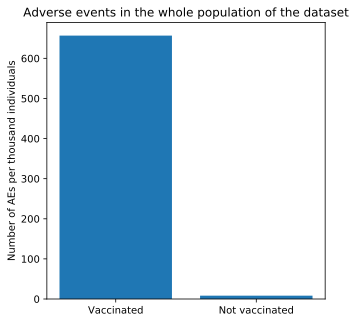

In [6]:
# Figure 1
SVG(filename='analysis_euler/1a_total_AE_barplot.svg')

A similar situation can be found when looking at whether a subject had one or multiple events (event) or none (no event). In the vaccinated group, adverse events were registered in 20'478 out of 146'457 subjects, whereas in the unvaccinated group, there were only 824 out of 605'460 subjects with adverse events, as seen in table 1.

In [8]:
# Table 1
table = pd.read_csv('analysis_euler/1a_contigency_table.csv') 
table


,Unnamed: 0,event,no event,Total
0,Vaccinated,20478.0,125979.0,146457.0
1,Not vaccinated,824.0,501636.0,502460.0
2,Total,21302.0,627615.0,648917.0


A Chi-Squared Test of Independence was performed to examine the relation between the vaccination status and the ocurrence of an adverse event. The relation between these two variables was significant (X2 (1, N = 648917) = 68197.21, p = .0), with the occurrence of an adverse event being more likely in the vaccinated subjects.

The risk of experiencing an adverse event among vaccinated subjects was 85.3 times higher than among unvaccinated subjects (RR: 85.3, CI: 79.5 - 91.38).

### 1b) Same comparison in subset of subjects with underlying medical condition

When looking only at subjects with an underlying medical condition, there were 657.4  and 103.4 adverse events registered per thousand individuals, in the vaccinated and in the unvaccinated group, respectively. This is visualised in Figure 2.

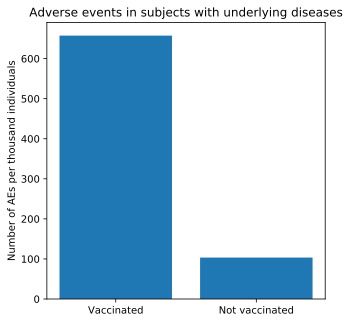

In [7]:
# Figure 2
SVG(filename='analysis_euler/1b_total_AE_barplot.svg')

When again focusing on the occurrence of one or multiple events (event) or none (no event), there were relatively more vaccinated (20'473 of 146'167) than unvaccinated patients (807 of 39'972) with at least one adverse event, as seen in table 2.

In [9]:
# Table 2
table = pd.read_csv('analysis_euler/1b_contigency_table.csv') 
table


,Unnamed: 0,event,no event,Total
0,Vaccinated,20473.0,125694.0,146167.0
1,Not vaccinated,807.0,39165.0,39972.0
2,Total,21280.0,164859.0,186139.0


The relation between these two variables, the vaccination status and the ocurrence of an adverse event, in this subgroup of patients with an underlying disease was significant (X2 (1, N = 186139) = 4453.611, p = .0), with the occurrence of an adverse event being more likely in the vaccinated subjects.

The risk of experiencing an adverse event among vaccinated subjects was 6.9 times higher than among unvaccinated subjects (RR: 6.9, CI: 6.5 - 7.4).

The risk ratios of analyses 1a) and 1b) are illustrated in figure 3.

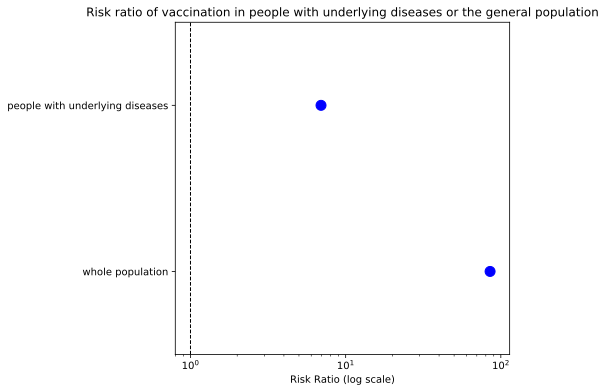

In [10]:
# da hemer iwie kein error balke, wemer das weglah?

# Figure 3
SVG(filename='analysis_euler/1a_b_RR_plot.svg')

### 1c) Same comparison in subset of subjects with specific underlying medical condition 

Fot this analysis, the effect of the vaccination on adverse events was evaluated in different underlying conditions defined according to the ICD-10 categories. The number of adverse events per thousand individuals is higher in vaccinated compared to unvaccinated subjects in each of the underlying disease categories, as can be appreciated in table 3 and figure 4.

In [11]:
# Table 3
table = pd.read_csv('analysis_euler/1c_total_AE_table.csv') 
table

,Unnamed: 0,Vaccinated,Not vaccinated
0,Diseases of the blood and blood-forming organs...,972.338596,176.300256
1,"Congenital malformations, deformations and chr...",852.380742,164.902309
2,"Endocrine, nutritional and metabolic diseases",830.559321,156.156003
3,Diseases of the circulatory system,822.174792,151.051541
4,Diseases of the eye and adnexa,795.725800,148.083433
5,Diseases of the nervous system,791.098325,159.006211
6,Neoplasms,770.085871,138.232937
7,Diseases of the ear and mastoid process,759.705276,150.590948
8,Diseases of the digestive system,757.124218,145.601534
9,Diseases of the respiratory system,734.655083,134.365325


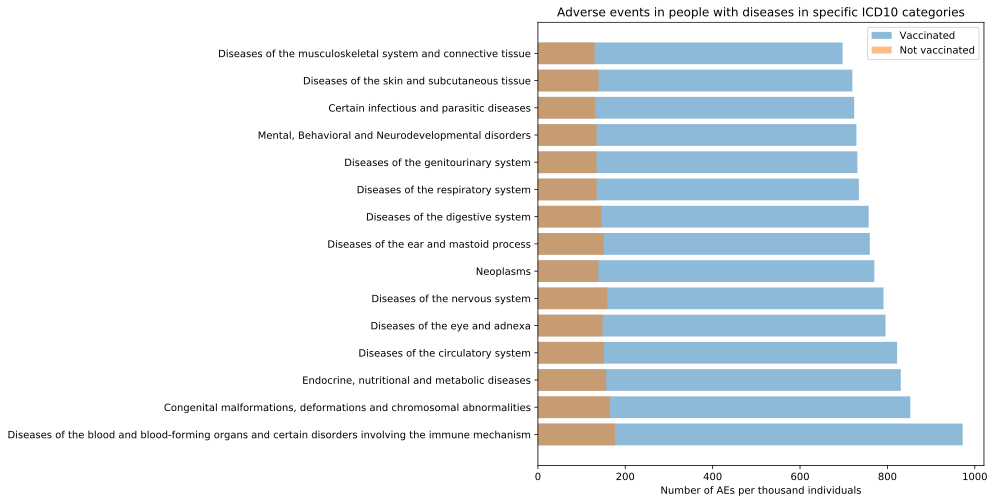

In [12]:
# Figure 4
SVG(filename='analysis_euler/1c_AE_barplot.svg')

Vaccination status had a significant effect on the occurrence of at least one adverse event in all of the subgroups, with adverse events being more likely in the vaccinated individuals. The risk of experiencing an adverse event was between 5 and 7 times higher in vaccinated subjects in the different underlying conditions. The p-value of the chi-squared test, the risk ratio and its 95%-CI for the subgroups are listed in table 4. Figure 5 depicts the ratios.

In [13]:
# Table 4
table = pd.read_csv('analysis_euler/1c_chi_square_RR_table.csv') 
table

,Unnamed: 0,P-value,Significant,Risk Ratio,Confidence Interval
0,Certain infectious and parasitic diseases,0.000000e+00,Yes,6.07,"(5.64, 6.54)"
1,Neoplasms,0.000000e+00,Yes,6.29,"(5.72, 6.92)"
2,Diseases of the blood and blood-forming organs...,4.778668e-293,Yes,5.93,"(5.28, 6.65)"
3,"Endocrine, nutritional and metabolic diseases",0.000000e+00,Yes,5.75,"(5.3, 6.24)"
4,"Mental, Behavioral and Neurodevelopmental diso...",0.000000e+00,Yes,5.97,"(5.55, 6.42)"
5,Diseases of the nervous system,0.000000e+00,Yes,5.66,"(5.22, 6.14)"
6,Diseases of the eye and adnexa,0.000000e+00,Yes,5.69,"(5.22, 6.2)"
7,Diseases of the ear and mastoid process,0.000000e+00,Yes,6.25,"(5.7, 6.86)"
8,Diseases of the circulatory system,0.000000e+00,Yes,6.04,"(5.58, 6.53)"
9,Diseases of the respiratory system,0.000000e+00,Yes,6.03,"(5.6, 6.49)"


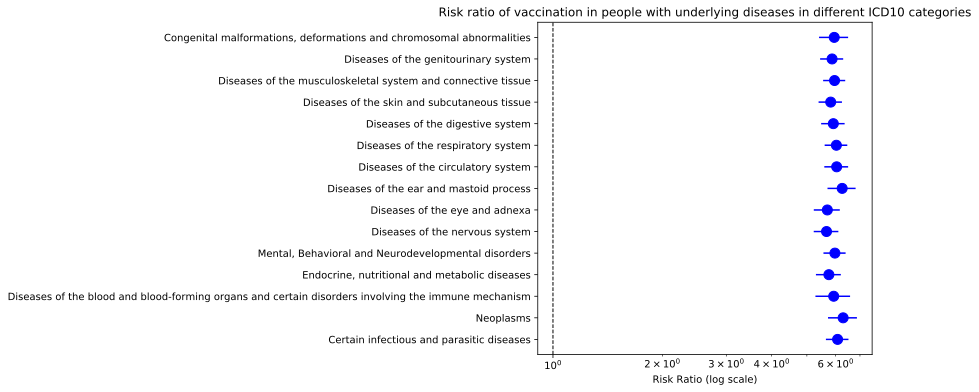

In [14]:
# Figure 5
SVG(filename='analysis_euler/1c_AE_RR.svg')

## 2) Effect of the vaccination on mortality

### 2a) Comparison of mortality rate after vaccination of vaccinated and unvaccinated people

When comparing the number of deaths of the entire study population, vaccinated people showed a higher mortality rate (0.826 per thousand subjects) than the unvaccinated group (0.738 per thousand subjects). Table 5 lists the subjects that died (event) and the subjects that did not die (no event) since the vaccination date or the randomly allocated issue date, respectively.

In [15]:
# Table 5
table = pd.read_csv('analysis_euler/2a_contigency_table.csv') 
table

,Unnamed: 0,event,no event,Total
0,Vaccinated,121.0,146336.0,146457.0
1,Not vaccinated,371.0,502089.0,502460.0
2,Total,492.0,648425.0,648917.0


The relation between vaccination and death in the entire study population was not significant (X2 (1, N = 648917) = 1.041, p = .308), with the occurrence of death being more likely in the unvaccinated subjects.

The risk of experiencing an adverse event among vaccinated subjects was 1.1 times higher than among unvaccinated subjects (RR: 1.1, CI: 0.91 - 1.37).

### 2b) Same comparison in subset of subjects with underlying medical condition

When subset the population to only the subjects with underlying medical conditions, the unvaccinated people showed a higher mortality rate (2.051 per thousand subjects) than the vaccinated group (0.828 per thousand subjects). Table 6 lists the subjects that died (event) and the subjects that did not die (no event) since after the vaccination or the randomly allocated issue date, respectively.

In [16]:
# Table 6
table = pd.read_csv('analysis_euler/2b_contigency_table.csv') 
table 

,Unnamed: 0,event,no event,Total
0,Vaccinated,121.0,146046.0,146167.0
1,Not vaccinated,82.0,39890.0,39972.0
2,Total,203.0,185936.0,186139.0


The vaccination status had a significant effect on death (X2 (1, N = 186139) = 23.376, p = .0), with the unvaccinated subjects being more likely to die compared to the unvaccinated individuals.

The risk of death among vaccinated subjects was 0.4 times as high as among unvaccinated subjects (RR: 0.4, CI: 0.30 - 0.53).

The risk ratios of analyses 2a) and 2b) are illustrated in figure 6.

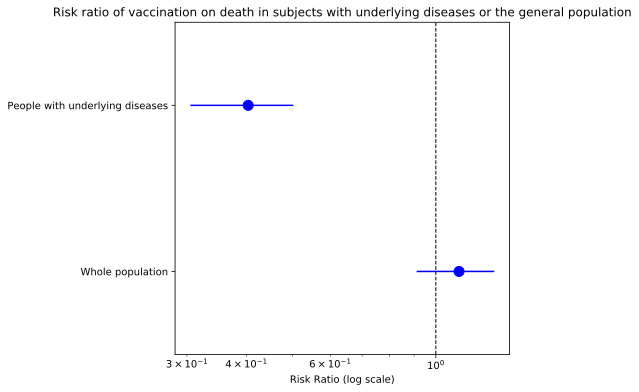

In [17]:
# Figure 6
SVG(filename='analysis_euler/2a_b_RR_plot.svg')

### 2c) Same comparison in subset of subjects with specific underlying medical condition 

Fot this last analysis, the effect of the vaccination on death was evaluated in different underlying conditions according to the ICD-10 categories. The number of deaths per thousand subjects was lower in vaccinated compared to unvaccinated subjects in each of the underlying disease categories, as can be appreciated in table 6 and figure 7.

In [18]:
# Table 6
table = pd.read_csv('analysis_euler/2c_total_mortality_table.csv') 
table

,Unnamed: 0,Vaccinated,Not vaccinated
0,Diseases of the blood and blood-forming organs...,1.581444,4.677581
1,Neoplasms,1.226734,2.959492
2,Diseases of the circulatory system,1.092706,3.042194
3,"Congenital malformations, deformations and chr...",1.090529,3.055062
4,Diseases of the eye and adnexa,1.089187,2.948564
5,"Endocrine, nutritional and metabolic diseases",1.033310,3.160846
6,Diseases of the nervous system,1.026682,2.732919
7,Diseases of the ear and mastoid process,0.931329,2.882675
8,Diseases of the digestive system,0.926574,2.708672
9,Diseases of the respiratory system,0.920351,2.549627


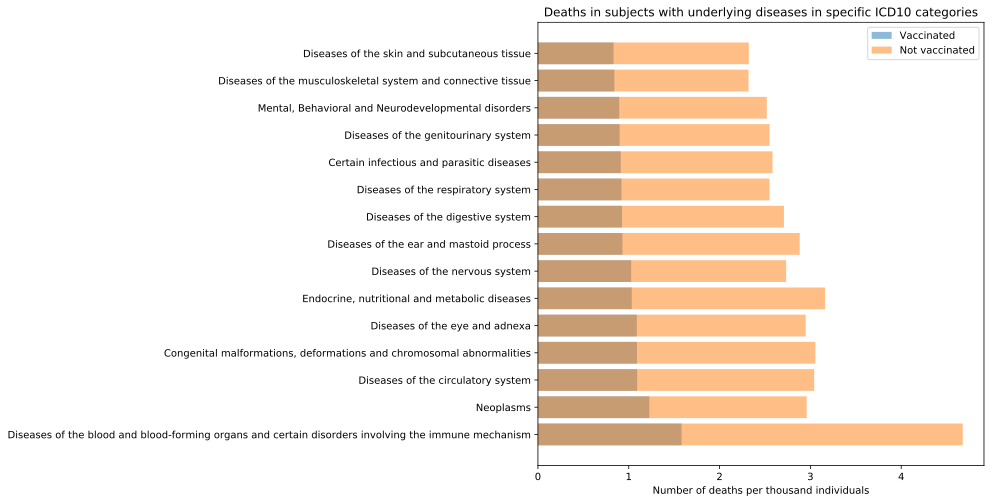

In [19]:
# Figure 7
SVG(filename='analysis_euler/2c_deaths_barplot.svg')

A Chi-Squared Test of Independence was performed for each of the underlying disease categories in order to examine the relationship between the vaccination status and the ocurrence of death. The relationship between these two variables was significant for all of the subgroups, with death being more likely in the unvaccinated subjects. Further, the risk ratio and its 95% confidence interval was calculated for each subgroup, whereas vaccinated individuals had between 0.3 and 0.4 times the risk of dying compared to unvaccinated subjects. The p-value of the chi-squared test, the risk ratio and its CI for the subgroups are listed in table 7. Figure 8 depicts the risk ratios.

In [20]:
# Table 7
table = pd.read_csv('analysis_euler/2c_chi_square_RR_table.csv') 
table

,Unnamed: 0,P-value,Significant,Risk Ratio,Confidence Interval
0,Certain infectious and parasitic diseases,9.549588e-13,Yes,0.35,"(0.26, 0.47)"
1,Neoplasms,1.030402e-06,Yes,0.41,"(0.29, 0.59)"
2,Diseases of the blood and blood-forming organs...,4.297056e-08,Yes,0.34,"(0.23, 0.5)"
3,"Endocrine, nutritional and metabolic diseases",1.437963e-12,Yes,0.33,"(0.24, 0.45)"
4,"Mental, Behavioral and Neurodevelopmental diso...",2.256728e-12,Yes,0.36,"(0.26, 0.48)"
5,Diseases of the nervous system,4.592065e-09,Yes,0.38,"(0.27, 0.52)"
6,Diseases of the eye and adnexa,2.176042e-09,Yes,0.37,"(0.26, 0.52)"
7,Diseases of the ear and mastoid process,9.364046e-11,Yes,0.32,"(0.23, 0.46)"
8,Diseases of the circulatory system,8.270185e-12,Yes,0.36,"(0.27, 0.49)"
9,Diseases of the respiratory system,8.643481e-12,Yes,0.36,"(0.27, 0.49)"


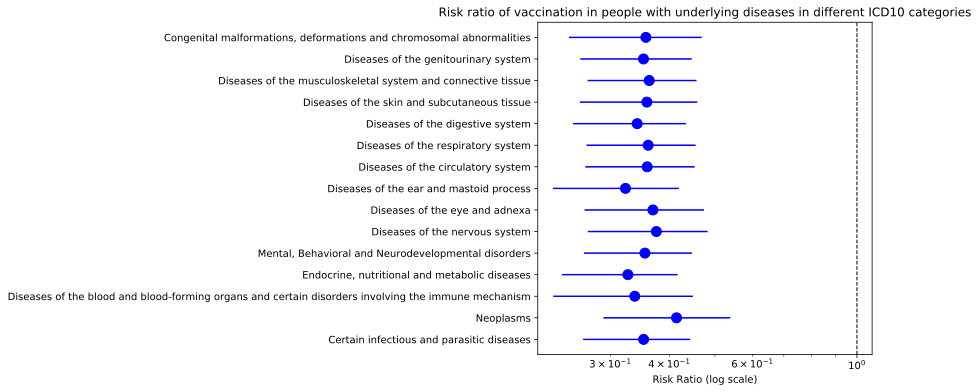

In [21]:
# Figure 8
SVG(filename='analysis_euler/2c_deaths_RR.svg')

# 4. Discussion
The sample size as well as the number of vaccinated and unvaccinated people was comparable to Xiang et al. While we retrieved 186'139 individuals with underlying diseases with 146'167 vaccinated and 39'972 unvaccinated individuals, Barda et al. retrieved 180'727 with 145’455 vaccinated and 33'926 unvaccinated individuals. This was expected, as they also used the UKBB dataset and extracted it around the same time (June 2021). \
However, the number of AEs and risk ratio of AEs being higher in most vaccinated group was not expected. Conversely, the number of deaths and risk ratio of deaths was lower in most vaccinated group. Both could be explained by confounders such as age, as older people had higher priority in getting the vaccine. This could be corrected for example through regression analysis as done by Xiang et al. or by matching unvaccinated and vaccinated persons as done by Barda et al.\
The analysis has several strengths and limitations. One strength of this analysis is the limitation of the survival bias by prescription-time distribution matching by allocating a random date out of the issue dates of the vaccinated individuals to each unvaccinated individual. Further, we have found no preceding analysis of the effect of covid vaccination on people with specific underlying disease categories. Limitations include the calculation of a risk ratio instead of the time-related hazard ratio (as done by Xiang et al.) and the calculation of occurrences in general as opposed to the incidence, which would be the number of events within a given time frame. The confidence interval of the risk ratio would better be analysed with the percentile bootstrap method as described by Barda et al. \
Further next steps could be taken after optimizing the analysis method. First, the risk/hazard ratio of getting the vaccine could be compared to getting SARS-Cov-2 to put things in perspective. Second, the time of AEs and deaths could be analysed. Third, more specific underlying diseases that could be of relevance in this context such as myocarditis, thrombosis or lymphadenopathy could be analysed. Finally, a subgroup of fully vaccinated people as opposed to the here analysed group with at least one vaccine within the most recent dataset could be analysed.

# References
Choi, W. S. & Cheong, H. J. COVID-19 Vaccination for People with Comorbidities. Infect Chemother 53, 155-158, doi:10.3947/ic.2021.0302 (2021).